# Filtracja Non-Local Means

## Definicja

Kolejny "poziom wtajemniczenia" w zagadnienie filtracji obrazów to metoda _Non-Local Means_ (NLM).
Została ona zaproponowana w pracy *A non-local algorithm for image denoising* (autorstwo: Antoni Buades, Bartomeu Colli i Jean Michel Morel) na konferencji CVPR w 2005 roku.

Filtr NLM dany jest zależnością:

\begin{equation}
\hat{I}(\mathbf{x}) = \sum_{\mathbf{p} \in V(\mathbf{x})} w(\mathbf{p},\mathbf{x})I(\mathbf{p}),
\end{equation}

gdzie:
- $I$ - obraz wejściowy,
- $\hat{I}$ - obraz wyjściowy (przefiltrowany),
- $\mathbf{x}$ - współrzędne piksela obrazu,
- $V(\mathbf{x})$ - obszar poszukiwań piksela, dla którego przeprowadzana jest filtracja,
- $w$ - waga punktu $\mathbf{p}$ z obszaru poszukiwań.

Wróćmy na chwilę do filtracji bilateralnej. Tam waga danego piksela z kontekstu zależała od dwóch czynników - odległości przestrzennej pomiędzy pikselami oraz różnicy w jasności / kolorze pomiędzy pikselami (tzw. przeciwdziedzina).
Filtr NLM stanowi uogólnienie tej metody - do obliczania wag nie wykorzystuje się już pojedynczych pikseli ($\mathbf{p}$ i $\mathbf{x}$), a lokalne konteksty ($N(\mathbf{p})$ i $N(\mathbf{x})$).

Waga $w$ dana jest następującą zależnością:

\begin{equation}
w(\mathbf{p},\mathbf{x}) = \frac{1}{Z(\mathbf{x})}\exp\left(-\frac{|| v(N(\mathbf{p})) - v(N(\mathbf{x})) ||^2_{2}}{\alpha \sigma^2}\right),
\end{equation}

gdzie:
- \begin{equation}
Z(\mathbf{x}) = \sum_{\mathbf{p} \in  V(\mathbf{x})} \exp\left(-\frac{|| v(N(\mathbf{p})) - v(N(\mathbf{x})) ||^2_{2}}{\alpha \sigma^2}\right),
\end{equation}
- $|| \cdot ||$ - jest normą $L_2$ odległości pomiędzy dwoma kontekstami,
- $v$ oznacza mnożenie punktowe kontekstu $N$ przez dwuwymiarową maskę Gaussa o odpowiadających kontekstowi wymiarach,
- $\alpha$ > 0 - parametr sterujący filtracją,
- $\sigma$ - parametr szumu stacjonarnego występującego na obrazie (w przypadku szumu niestacjonarnego, parametr $\sigma$ musi zostać dopasowany lokalnie, tj. $\sigma = \sigma(\mathbf{x})$).

## Analiza działania

Zastanówmy się teraz, jak działa filtracja NLM. Najprościej to zrozumieć na rysunku.

![Ilustracja NLM](https://raw.githubusercontent.com/vision-agh/poc_sw/master/07_Bilateral/nlm.png)

1. Dla rozważanego piksela $\mathbf{x}$ definiujemy obszar poszukiwań $V(\mathbf{x})$. Uwaga - obszar poszukiwań ($V$) jest jednostką większą niż otoczenie / kontekst ($N$).

2. Następnie, dla każdego z pikseli $\mathbf{p} \in  V(\mathbf{x})$ oraz samego $\mathbf{x}$ definiujemy otoczenie / kontekst, odpowiednio $N(\mathbf{p})$ i $N(\mathbf{x})$.

3. Wracamy do równania definiującego wagę  $w(\mathbf{p},\mathbf{x})$, a konkretnie do wyrażenia $|| v(N(\mathbf{p})) - v(N(\mathbf{x})) ||$. Przeanalizujmy, co ono oznacza. Mamy dwa otoczenia: $N(\mathbf{p})$ i $N(\mathbf{x})$. Każde z nich mnożymy przez odpowiadającą maskę Gaussa - funkcja $v$. Otrzymujemy dwie macierze, które odejmujemy od siebie punktowo. Następnie obliczamy kwadrat z normy $L_2$, którą definiujemy jako $||X||_2 = \sqrt{\sum_k|X_k|^2}$. Otrzymujemy zatem jedną liczbę, która opisuje nam podobieństwo otoczeń pikseli $\mathbf{x}$ i $\mathbf{p}$. Mała wartość oznacza otoczenia zbliżone, duża - różniące się. Ponieważ, z dokładnością do stałych, liczba ta stanowi wykładnik funkcji $e^{-x}$, to ostatecznie waga jest zbliżona do 1 dla otoczeń podobnych, a szybko maleje wraz z malejącym podobieństwem kontekstów.

4. Podsumowując: jak wynika z powyższej analizy, filtr NLM to taki filtr bilateralny, w którym zamiast pojedynczych pikseli porównuje się ich lokalne otoczenia. Wpływa to pozytywnie na jakość filtracji, niestety kosztem złożoności obliczeniowej.

## Implementacja

W ramach zadania należy zaimplementować filtr NLM, ocenić jego działanie w porównaniu do filtrów Gaussa i bilateralnego oraz dokonać pomiaru czasu obliczeń (dla trzech wymienionych metod).

Jak już się zrozumie, jak działa NLM, jego implementacja jest dość prosta.
Wartość parametru $\alpha$ należy dobrać eksperymentalnie.
Nie należy także "przesadzić" z rozmiarem obszaru poszukiwań (np. 11x11) oraz kontekstu (5x5 lub 3x3).

Wskazówki do implementacji:
- algorytm sprowadza się do dwóch podwójnych pętli `for`: zewnętrzne po pikselach, wewnętrzne po kolejnych obszarach przeszukiwań,
- przed realizacją trzeba przemyśleć problem pikseli brzegowych - de facto problemów jest kilka. Po pierwsze nie dla każdego piksela można wyznaczyć pełny obszar przeszukiwań (tu propozycja, aby filtrację przeprowadzać tylko dla pikseli z pełnym obszarem). Po drugie, ponieważ rozpatrujemy konteksty, to nawet dla piksela o "pełnym" obszarze przeszukiwań, będą istnieć piksele, dla których nie ma pełnych kontekstów (sugestia - powiększyć obszar przeszukiwań, tak aby zawierał konteksty). Ostatni problem jest bardziej techniczny / implementacyjny. Jeśli w kolejnych iteracjach "jawnie" wytniemy fragment o rozmiarach obszaru przeszukiwań, to znowu pojawi się problem brzegowy - tu można albo wyciąć nieco większy obszar, albo cały czas "pracować" na obrazie oryginalnym ("żonglerka indeksami"),
- warto sprawdzać indeksy i rozmiary "wycinanych" kontekstów,
- wagi wyliczamy w trzech krokach:
    - obliczenia dla $N(\mathbf{x})$ + inicjalizacja macierzy na wagi,
    - podwójna pętla, w której przeprowadzamy obliczenia dla kolejnych $N(\mathbf{p})$ oraz wyliczamy wagi,
    - normalizacja macierzy wag oraz końcowa filtracja obszaru z wykorzystaniem wag.
- uwaga, obliczenia trochę trwają, nawet dla obrazka 256x256 i względnie niewielkich obszarów przeszukiwań i kontekstu.

Efekt końcowy:
- porównanie wyników metod: filtr Gaussa, filtr bilateralny oraz filtr NLM (2-3 zdania komentarza),
- porównanie czasu działania powyższych metod (1 zdanie komentarza).


In [1]:
import cv2
import os
import requests
from matplotlib import pyplot as plt
import numpy as np
from scipy import signal
from scipy.io import loadmat
import math

url = 'https://raw.githubusercontent.com/vision-agh/poc_sw/master/07_Bilateral/'
fileNames = ["MR_data.mat"]

for fileName in fileNames:
    if not os.path.exists(fileName):
        r = requests.get(url + fileName, allow_redirects=True)
        open(fileName, 'wb').write(r.content)

In [2]:
# skopiowane funkcje z podstawowej części laboratorium, na potrzeby porównania
def show_image(image, name):
    plt.title(f"{name} image")
    plt.imshow(image, 'gray')
    plt.axis('off')

def gaussian_filter(window, delta_s):
    coeffs = np.zeros((window, window))
    
    for i in range(-window // 2, window // 2 + 1):
        for j in range(-window // 2, window // 2 + 1):
            coeffs[i + window // 2, j + window // 2] = np.exp(-np.linalg.norm([i**2, j**2]) / (2 * delta_s**2))

    return coeffs

def classic_convolution(image, window, coeffs):
    # kopia obrazu
    image_conv = image.copy()

    # pobranie wymiarów obrazu
    H, W = image.shape
    
    for i in range(window // 2, H - window // 2):
        for j in range(window // 2, W - window // 2):
            # aktualny kontekst
            context = image[i-window//2 : i+1+window//2, j-window//2 : j+1+window//2]
            
            image_conv[i, j] = new_pixel_value_conv(context, coeffs)

    return image_conv

def new_pixel_value_conv(context, coeffs):
    Wn = coeffs.sum()
    result = 1 / Wn * np.sum(coeffs * context)
    return result

def bilateral_filtering(image, window, delta_r, coeffs):
    # kopia obrazu
    image_bilateral = image.copy()

    # pobranie wymiarów obrazu
    H, W = image.shape
    
    for i in range(window // 2, H - window // 2):
        for j in range(window // 2, W - window // 2):
            # aktualny kontekst
            context = image[i-window//2 : i+1+window//2, j-window//2 : j+1+window//2]
            
            image_bilateral[i, j] = new_pixel_value_bilateral(context, coeffs, delta_r)

    return image_bilateral

def new_pixel_value_bilateral(context, coeffs, delta_r):
    # obliczanie nowych współczynników filtra
    new_coeffs = coeffs.copy()
    window = coeffs.shape[0]
    
    for i in range(window):
        for j in range(window):
            new_coeffs[i, j] *= dist(context[i, j].astype(np.int32) - context[window//2, window//2].astype(np.int32), delta_r)
    
    Wn = new_coeffs.sum()
    result = 1 / Wn * np.sum(new_coeffs * context)
    return result

def dist(y, delta_r):
    return np.exp(-y**2 / (2 * delta_r**2))

In [3]:
# algorytm filtracji NLM
def nlm_filtering(image, context_size, search_size, alpha, sigma, coeffs):
    # kopia obrazu
    image_nlm = image.copy()
    
    # pobranie wymiarów obrazu
    H, W = image.shape
    
    border = search_size // 2 + context_size // 2
    
    for i in range(border, H - border):
        for j in range(border, W - border):
            # obszar przeszukiwań z uwzględnieniem obszaru kontekstu
            search_area = image[i-border : i+border+1, j-border : j+border+1]
    
            image_nlm[i, j] = new_pixel_value_nlm(search_area, context_size, search_size, coeffs, alpha, sigma)

    return image_nlm

In [4]:
# funkcja obliczająca nową wartość piksela - filtracja NLM
def new_pixel_value_nlm(search_area, context_size, search_size, coeffs, alpha, sigma):
    # obliczenie v(N(x))
    vNx = coeffs * search_area[search_size//2 : search_size//2 + context_size, search_size//2 : search_size//2 + context_size]

    # inicjalizacja macierzy na wagi
    weights = np.zeros((search_size, search_size))

    for i in range(search_size):
        for j in range(search_size):
            vNp = coeffs * search_area[i : i + context_size, j : j + context_size]
            weights[i, j] = np.exp(-np.linalg.norm(vNp - vNx) / (alpha * sigma**2))

    weights /= weights.sum()
    result = np.sum(weights * search_area[context_size//2 : search_size + context_size//2, context_size//2 : search_size + context_size//2])
    return result

In [5]:
# funkcja do porównania obrazów po różnych filtracjach
def compare(conv, bilateral, nlm):
    fig, axs = plt.subplots(1, 3)
    fig.set_size_inches(18, 6)
    
    axs[0].set_title("Classic convolution")
    axs[0].imshow(conv, 'gray', vmin=0, vmax=255)
    axs[0].axis('off')
    
    axs[1].set_title("Bilateral filtering")
    axs[1].imshow(bilateral, 'gray', vmin=0, vmax=255)
    axs[1].axis('off')
    
    axs[2].set_title("NLM filtering")
    axs[2].imshow(nlm, 'gray', vmin=0, vmax=255)
    axs[2].axis('off')
    
    plt.show()

In [6]:
# wczytanie danych
mat = loadmat('MR_data.mat')

# parametry (wspólne dla wszystkich filtrów)
window = context_size = 5
delta_s = 0.75
search_size = 11
alpha = 1.0

# obliczanie współczynników filtra
coeffs = gaussian_filter(window, delta_s)

### Porównanie filtracji dla wszystkich obrazów

#### _I_noisefree_

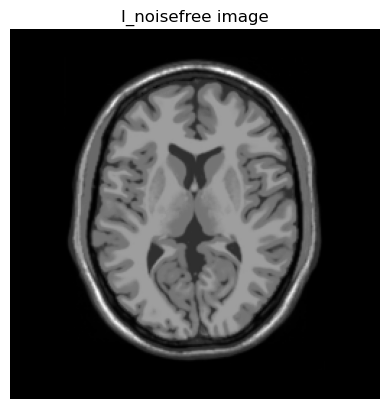

In [7]:
noisefree = mat['I_noisefree']
show_image(noisefree, 'I_noisefree')

Czas wykonania dla klasycznej filtracji Gaussowskiej
CPU times: total: 547 ms
Wall time: 545 ms

Czas wykonania dla filtracji bilateralnej
CPU times: total: 9.08 s
Wall time: 9.1 s

Czas wykonania dla filtracji NLM
CPU times: total: 48.4 s
Wall time: 48.5 s



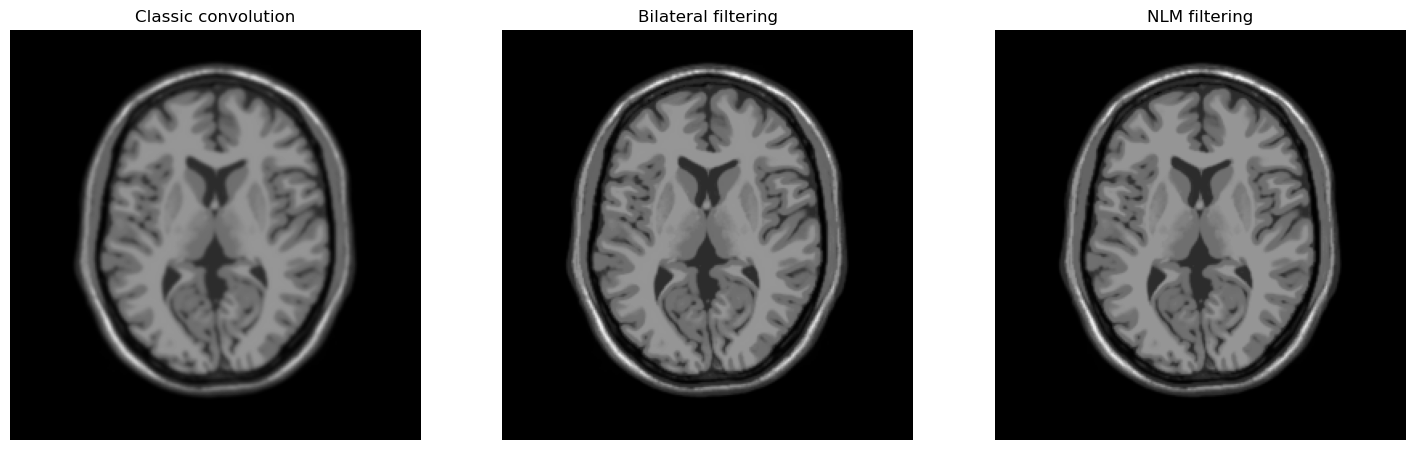

In [8]:
# klasyczna konwolucja
print("Czas wykonania dla klasycznej filtracji Gaussowskiej")
%time noisefree_conv = classic_convolution(noisefree, window, coeffs)

# filtracja bilateralna
delta_r = 0.5
print("\nCzas wykonania dla filtracji bilateralnej")
%time noisefree_bilateral = bilateral_filtering(noisefree, window, delta_r, coeffs)

# filtracja NLM
sigma = 1.0
print("\nCzas wykonania dla filtracji NLM")
%time noisefree_nlm = nlm_filtering(noisefree, context_size, search_size, alpha, sigma, coeffs)

# porównanie efektów wszystkich filtracji
print()
compare(noisefree_conv, noisefree_bilateral, noisefree_nlm)

#### _I_noisy1_

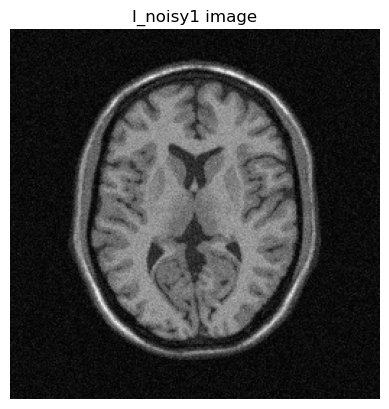

In [9]:
noisy1 = mat['I_noisy1']
show_image(noisy1, 'I_noisy1')

Czas wykonania dla klasycznej filtracji Gaussowskiej
CPU times: total: 516 ms
Wall time: 520 ms

Czas wykonania dla filtracji bilateralnej
CPU times: total: 9.12 s
Wall time: 8.81 s

Czas wykonania dla filtracji NLM
CPU times: total: 47.8 s
Wall time: 47.9 s



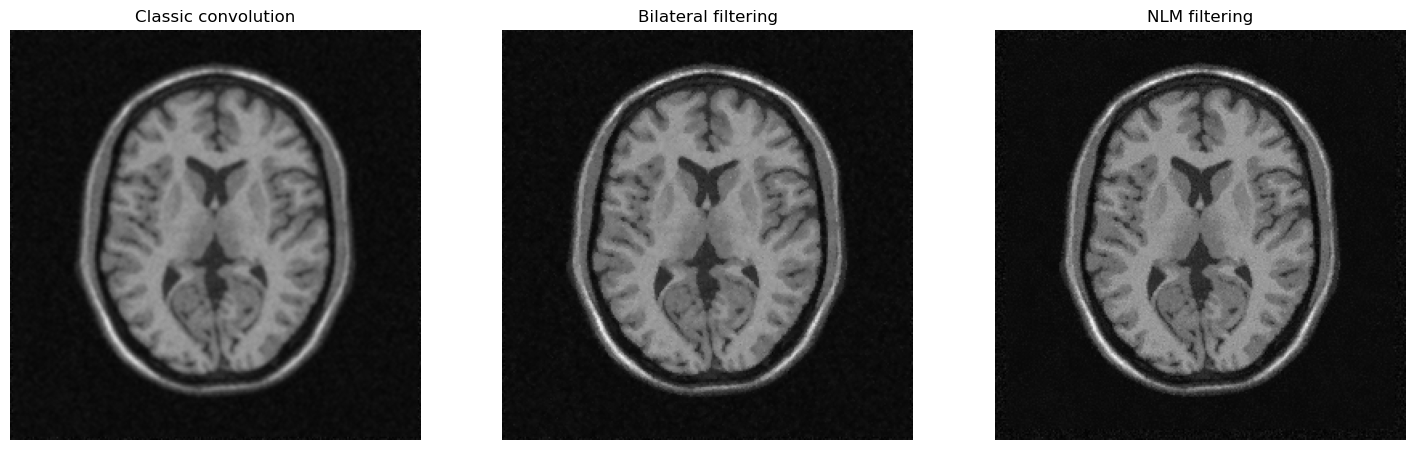

In [10]:
# klasyczna konwolucja
print("Czas wykonania dla klasycznej filtracji Gaussowskiej")
%time noisy1_conv = classic_convolution(noisy1, window, coeffs)

# filtracja bilateralna
delta_r = 20.0
print("\nCzas wykonania dla filtracji bilateralnej")
%time noisy1_bilateral = bilateral_filtering(noisy1, window, delta_r, coeffs)

# filtracja NLM
sigma = 2.5
print("\nCzas wykonania dla filtracji NLM")
%time noisy1_nlm = nlm_filtering(noisy1, context_size, search_size, alpha, sigma, coeffs)

# porównanie efektów wszystkich filtracji
print()
compare(noisy1_conv, noisy1_bilateral, noisy1_nlm)

#### _I_noisy2_

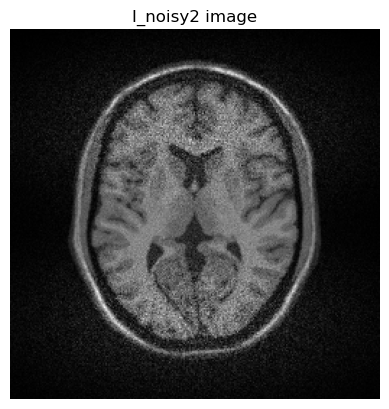

In [11]:
noisy2 = mat['I_noisy2']
show_image(noisy2, 'I_noisy2')

Czas wykonania dla klasycznej filtracji Gaussowskiej
CPU times: total: 484 ms
Wall time: 505 ms

Czas wykonania dla filtracji bilateralnej
CPU times: total: 9 s
Wall time: 8.77 s

Czas wykonania dla filtracji NLM
CPU times: total: 47.9 s
Wall time: 48.1 s



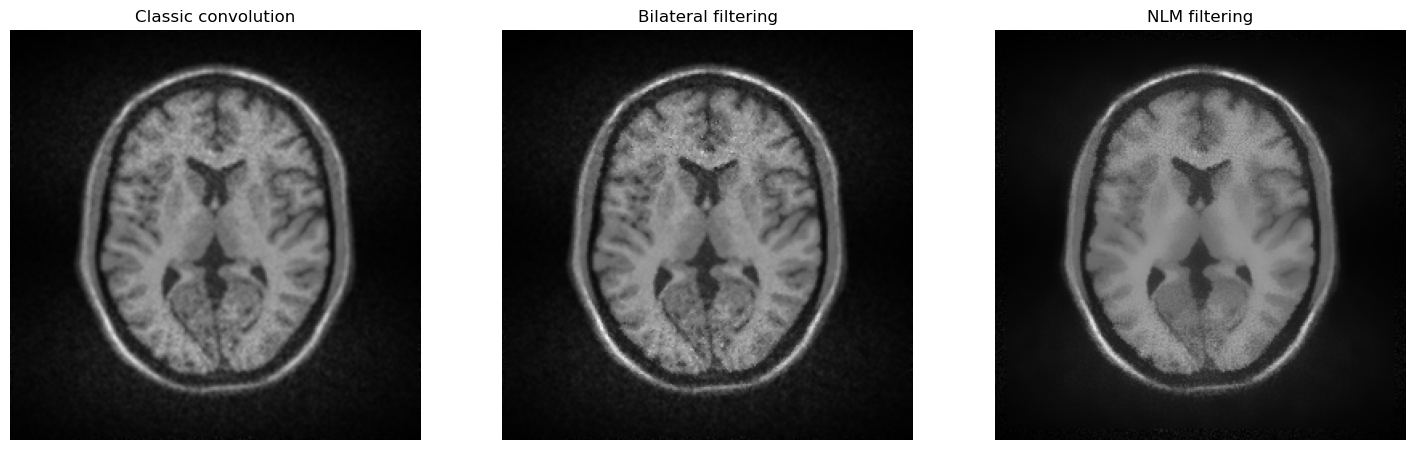

In [12]:
# klasyczna konwolucja
print("Czas wykonania dla klasycznej filtracji Gaussowskiej")
%time noisy2_conv = classic_convolution(noisy2, window, coeffs)

# filtracja bilateralna
delta_r = 60.0
print("\nCzas wykonania dla filtracji bilateralnej")
%time noisy2_bilateral = bilateral_filtering(noisy2, window, delta_r, coeffs)

# filtracja NLM
sigma = 6.0
print("\nCzas wykonania dla filtracji NLM")
%time noisy2_nlm = nlm_filtering(noisy2, context_size, search_size, alpha, sigma, coeffs)

# porównanie efektów wszystkich filtracji
print()
compare(noisy2_conv, noisy2_bilateral, noisy2_nlm)

#### _I_noisy3_

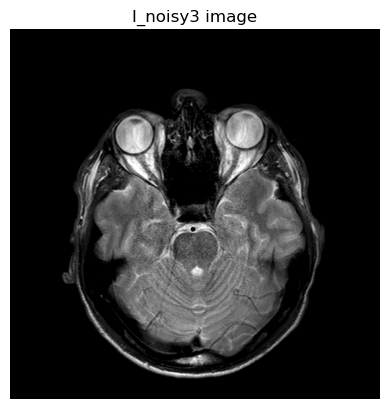

In [13]:
noisy3 = mat['I_noisy3']
show_image(noisy3, 'I_noisy3')

Czas wykonania dla klasycznej filtracji Gaussowskiej
CPU times: total: 2.64 s
Wall time: 2.64 s

Czas wykonania dla filtracji bilateralnej
CPU times: total: 42.2 s
Wall time: 42.3 s

Czas wykonania dla filtracji NLM
CPU times: total: 4min 12s
Wall time: 4min 14s



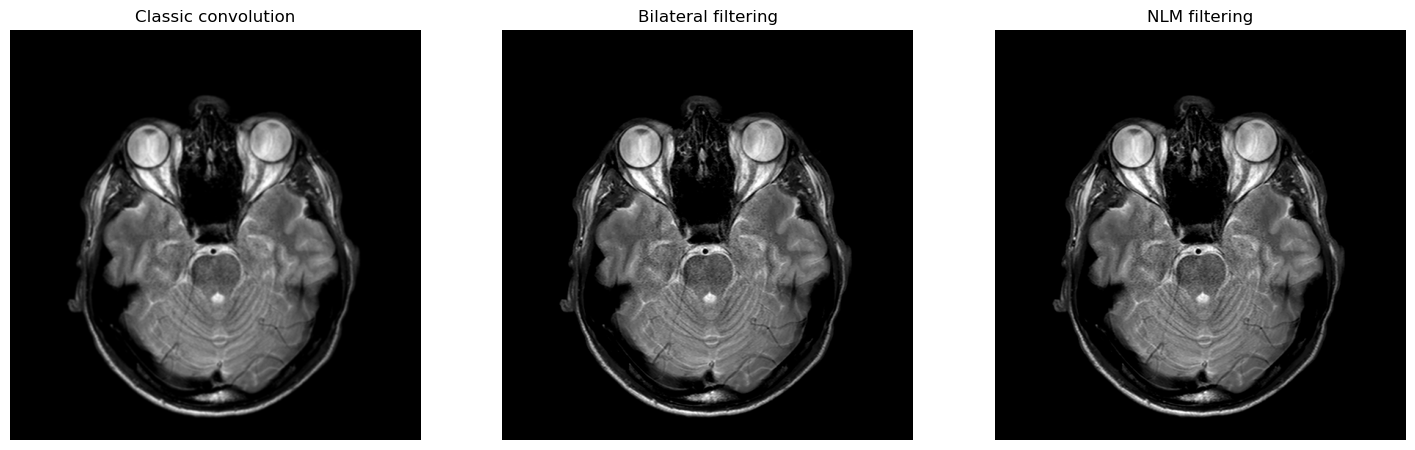

In [14]:
# klasyczna konwolucja
print("Czas wykonania dla klasycznej filtracji Gaussowskiej")
%time noisy3_conv = classic_convolution(noisy3, window, coeffs)

# filtracja bilateralna
delta_r = 5.0
print("\nCzas wykonania dla filtracji bilateralnej")
%time noisy3_bilateral = bilateral_filtering(noisy3, window, delta_r, coeffs)

# filtracja NLM
sigma = 1.5
print("\nCzas wykonania dla filtracji NLM")
%time noisy3_nlm = nlm_filtering(noisy3, context_size, search_size, alpha, sigma, coeffs)

# porównanie efektów wszystkich filtracji
print()
compare(noisy3_conv, noisy3_bilateral, noisy3_nlm)

#### _I_noisy4_

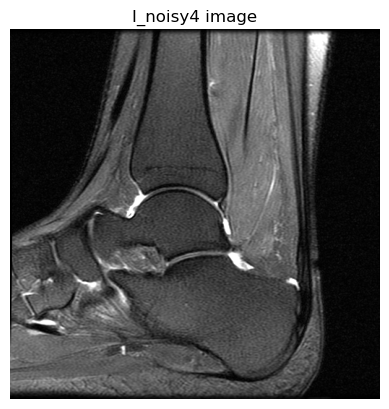

In [15]:
noisy4 = mat['I_noisy4']
show_image(noisy4, 'I_noisy4')

Czas wykonania dla klasycznej filtracji Gaussowskiej
CPU times: total: 2.3 s
Wall time: 2.31 s

Czas wykonania dla filtracji bilateralnej
CPU times: total: 37.3 s
Wall time: 37.2 s

Czas wykonania dla filtracji NLM
CPU times: total: 3min 36s
Wall time: 3min 38s



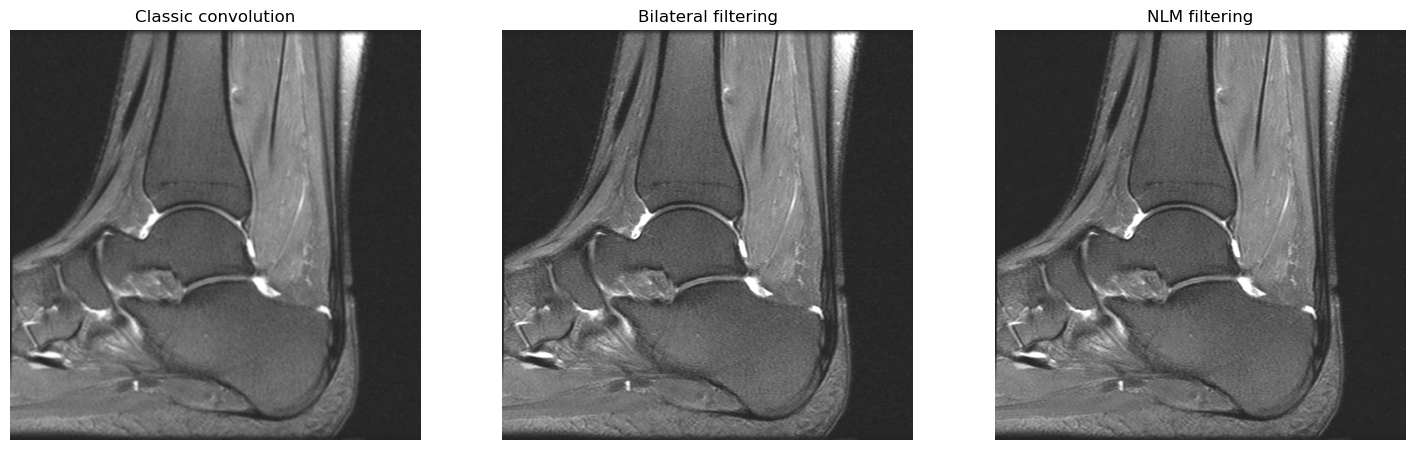

In [16]:
# klasyczna konwolucja
print("Czas wykonania dla klasycznej filtracji Gaussowskiej")
%time noisy4_conv = classic_convolution(noisy4, window, coeffs)

# filtracja bilateralna
print("\nCzas wykonania dla filtracji bilateralnej")
%time noisy4_bilateral = bilateral_filtering(noisy4, window, delta_r, coeffs)

# filtracja NLM
print("\nCzas wykonania dla filtracji NLM")
%time noisy4_nlm = nlm_filtering(noisy4, context_size, search_size, alpha, sigma, coeffs)

# porównanie efektów wszystkich filtracji
print()
compare(noisy4_conv, noisy4_bilateral, noisy4_nlm)

### Komentarze do zadania

#### Porównanie wyników metod

Dla wszystkich badanych obrazów przy klasycznej konwolucji widać spodziewane rozmycie, filtracja bilateralna już lepiej zachowuje krawędzie, a filtracja NLM radzi sobie podobnie - zapewne trochę lepiej (przynajmniej w założeniu), chociaż na przykładzie tych obrazów nie jest to może w aż tak dużym stopniu widoczne. Warto pamiętać o tym, że wiele zależy od odpowiedniego doboru współczynników, a niektóre z nich zależą od konkretnego przypadku i należy je "wyznaczyć" eksperymentalnie - mam nadzieję, że wybrałem sensowne ich wartości.

#### Porównanie czasu 
Dla badanych obrazków widać znaczne różnice w czasach filtrowania - dla mniejszych z nich (256x256) filtracja klasyczna jest najszybsza (około 0.5s), filtracja bilateralna jest o rząd wielkości wolniejsza (około 10s), natomiast najdłużej trwają obliczenia dla filtracji NLM (niecałą minutę), z kolei dla większych z nich (512x512) proporcje są podobne, a czasy około 4-5 razy większe dla każdej metody.